In [7]:
%matplotlib inline

import os
import json
import cv2
import math
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

In [123]:
joint_to_limb_heatmap_relationship = [
    [1,8],   [1,2],   [1,5],   [2,3],   [3,4],
    [5,6],   [6,7],   [8,9],   [9,10],  [10,11],
    [8,12],  [12,13], [13,14], [1,0],   [0,15],
    [15,17], [0,16],  [16,18]]

colors = [
    [255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0],
    [85, 255, 0], [0, 255, 0], [0, 255, 85], [0, 255, 170], [0, 255, 255],
    [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], [170, 0, 255],
    [255, 0, 255], [255, 0, 170], [255, 0, 85], [255, 0, 0], [255,0,0],
    [255,0,0], [255,0,0], [255,0,0], [255,0,0]]


def imshow(image):
    plt.imshow(image[:,:,[2,1,0]].astype(np.uint8))
    plt.show()

def add_pose_to_canvas(person_id, coors, canvas, limb_thickness=4):
    limb_type = 0
    labeled = False
    for joint_relation in  joint_to_limb_heatmap_relationship: # [1, 8] for example
        joint_coords = coors[joint_relation] # use it as indices 
        if 0 in joint_coords: # if a keypoint has 0
            # ignore keypoints that are not predicted
            limb_type += 1
            continue
        for joint in joint_coords:  # Draw circles at every joint
            if not labeled:
                font = cv2.FONT_HERSHEY_SIMPLEX
                cv2.putText(canvas, person_id,
                            tuple(joint[0:2].astype(int)), font,
                            2, (0,0,0), thickness=5)
                labeled = True
            cv2.circle(canvas, tuple(joint[0:2].astype(
                        int)), 4, (0,0,0), thickness=-1)
        coords_center = tuple(
                    np.round(np.mean(joint_coords, 0)).astype(int))
        limb_dir = joint_coords[0, :] - joint_coords[1, :]
        limb_length = np.linalg.norm(limb_dir)
        angle = math.degrees(math.atan2(limb_dir[1], limb_dir[0]))
        polygon = cv2.ellipse2Poly(
                    coords_center, (int(limb_length / 2), limb_thickness), int(angle), 0, 360, 1)
        cv2.fillConvexPoly(canvas, polygon, colors[limb_type])
        limb_type += 1
    return canvas

    
def draw_pose_figure(person_id, coors, height=1500, width=1500, limb_thickness=4):
    canvas = np.ones([height,width,3])*255
    canvas = canvas.astype(np.uint8)
    limb_type = 0
    return add_pose_to_canvas(person_id, coors, canvas, limb_thickness)


In [6]:
input_dir = '/Users/will.i.liam/Desktop/final_project/openpose/output/'
output_dir = '/Users/will.i.liam/Desktop/final_project/phoan/images/'
json_files = [pos_json for pos_json in os.listdir(input_dir) if 
              pos_json.endswith('.json')]

json_files = sorted(json_files)

In [81]:
frame = 376

In [82]:
frame = 376
data = json.load(open(input_dir + json_files[frame]))
person_1 = 0
person_id_1 = str(person_1) + ", " + str(data['people'][person_1]['person_id'])
a_keys_and_confs = np.array(data['people'][person_1]['pose_keypoints_2d']).reshape(-1, 3)

print("Person 1 ID")
print(data['people'][person_1]['person_id'])

# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

Person 1 ID
[0]


In [31]:
data = json.load(open(input_dir + json_files[frame+1]))
person_2 = 0
person_id_2 = str(person_2) + ", " + str(data['people'][person_2]['person_id'])
b_keys_and_confs = np.array(data['people'][person_2]['pose_keypoints_2d']).reshape(-1, 3)
print("Person 2 ID")
print(data['people'][person_2]['person_id'])


Person 2 ID
[80]


In [35]:
def distance(key_a, key_b, conf_a, conf_b):
    confs = conf_a * conf_b > 0
    confs = confs.reshape(-1, 1)
    
    print(np.sum(((key_a - key_b)**2)*(confs)) / np.sum(confs))

distance(a_keys_and_confs[:, :2],
         b_keys_and_confs[:, :2],
         a_keys_and_confs[:, 2],
         b_keys_and_confs[:, 2])



9.778973399999957


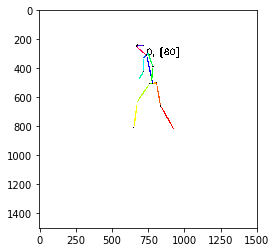

In [33]:
canvas = draw_pose_figure(person_id_1, 
                          a_keys_and_confs[:, :2])
imshow(canvas)

# read in a json file

# these preprocessing steps
"""
TO DO
interpolation
- by calculating the mean of the two neighbor values. 
- sliding window
We first removed missing data by applying linear interpolation to the raw time series for each body landmark. We then removed
outliers by using a rolling-median filter with a smoothing window of 1 second. In order
to obtain smooth signals, we then performed smoothing using a rolling-mean filter with a
smoothing window of 1 second. Outlier removal and smoothing provided a cleaner signal for
the extraction of kinematic variables

• If enough landmarks are available but some of them are
missing, then we can approximate occasional missing
data using spacial consistency, which means that missing
landmarks are estimated from coordinates of the available
landmarks;
• Persistent missing landmarks can be guessed by exploiting left and right side body symmetry;
we normalized x and y distances by the width and height
of the ground-truth bounding box around the infant.


discarding poses
- if root landmark is missing
- if more than 8 body landmarks are missing


Measuring movement in
body-centered coordinates allowed us to compensate for the effects of camera movement in
YouTube videos.

We rotated the upper-body landmarks relative to the angle of the
left and right shoulders with respect to the midpoint between the shoulders. We rotated
the lower-body landmarks relative to the angle of the left and right hip joints with respect
to the midpoint between the hip joints. 

basically, make the joints relative to each other instead of to the camera

"""



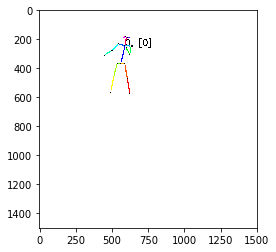

In [173]:
# normalized the landmark coordinates within each frame, 
# by subtracting a reference landmark (the neck) 
# and dividing by a reference distance (the trunk length)

def normalize_in_frame(frame):
    """
    expects frame in the order of openpose outputs
    [21, 2] where 2 corresponds to x- y- coordinates
    
    reduces the pixel coordinate size of each coordinate
    """
    neck = frame[1]
    subtracted = frame - neck
    trunk_length = np.sqrt(np.sum( (subtracted[8] - subtracted[1]) ** 2))
    divided = frame / trunk_length
    return divided

def adjust_to_canvas(poses):
    poses = poses * 125
    return poses, np.ones([np.int(poses[8][1] * 2),
                    np.int(poses[8][0] * 2), 3]) * 255

frame = 2000
data = json.load(open(input_dir + json_files[frame]))
person_1 = 0
person_id_1 = str(person_1) + ", " + str(data['people'][person_1]['person_id'])
a_keys_and_confs = np.array(data['people'][person_1]['pose_keypoints_2d']).reshape(-1, 3)
# normalized
divided = normalize_in_frame(a_keys_and_confs[:, :2])
adjusted_poses = divided * 125
canvas = draw_pose_figure(person_id_1, 
                          adjusted_poses)
results = np.hstack([divided, a_keys_and_confs[:, :2]])
imshow(canvas)

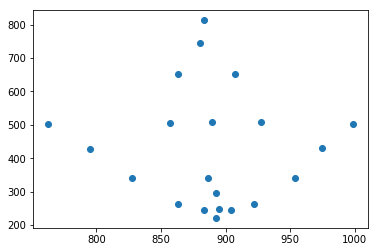

In [83]:
plt.figure()
plt.scatter(a_keys_and_confs[:, 0], a_keys_and_confs[:, 1])

[0. 0.]
[  2.792 164.925]


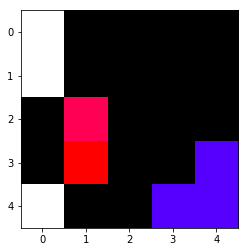

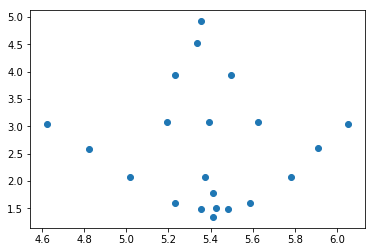

In [84]:
frame = a_keys_and_confs[:, :2]
neck = frame[1]

subtracted = frame - neck

print(subtracted[1])
print(subtracted[8])

trunk_length = np.sqrt(np.sum( (subtracted[8] - subtracted[1]) ** 2))

divided = frame / trunk_length

dims = 5
adjusted_canvas = np.ones([dims, dims, 3]) * 255

adjusted_canvas = add_pose_to_canvas(person_id_1, 
                                     divided, adjusted_canvas)
imshow(adjusted_canvas)

plt.figure()
plt.scatter(divided[:, 0], divided[:, 1])

In [171]:
neck = np.array([3, 3])
right_arm = np.array([5, 5])
trunk_length = 2

right_arm = (right_arm) / trunk_length
neck = (neck - neck) / trunk_length
print(right_arm)
print(neck)

[2.5 2.5]
[0. 0.]


In [172]:
neck = np.array([6, 6])
right_arm = np.array([10, 10])
trunk_length = 4

right_arm = (right_arm) / trunk_length
neck = (neck - neck) / trunk_length
print(right_arm)
print(neck)

[2.5 2.5]
[0. 0.]
